In [2]:
import pandas as pd

import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ardl_select_order, ARDL, UECM
import matplotlib.pyplot as plt


In [ ]:
rural_population_share = 64
urban_population_share = 36

df = pd.read_csv("energy-consumption-by-source-india/energy-consumption-by-source-and-country.csv")

df.head()

,Entity,Code,Year,Other renewables (including geothermal and biomass) - TWh,Biofuels consumption - TWh,Solar consumption - TWh,Wind consumption - TWh,Hydro consumption - TWh,Nuclear consumption - TWh,Gas consumption - TWh,...,Oil consumption - TWh,Other renewables (including geothermal and biomass) - TWh.1,Biofuels consumption - TWh.1,Solar consumption - TWh.1,Wind consumption - TWh.1,Hydro consumption - TWh.1,Nuclear consumption - TWh.1,Gas consumption - TWh.1,Coal consumption - TWh.1,Oil consumption - TWh.1
0,India,IND,1980,0.0,0.0,0.0,0.0,154.00380,6.800965,11.331031,...,376.81616,0.0,0.0,0.0,0.0,154.00380,6.800965,11.331031,659.56500,376.81616
1,India,IND,1981,0.0,0.0,0.0,0.0,164.11932,6.850070,19.781782,...,405.65527,0.0,0.0,0.0,0.0,164.11932,6.850070,19.781782,742.14240,405.65527
2,India,IND,1982,0.0,0.0,0.0,0.0,138.49908,5.990742,25.934563,...,422.65634,0.0,0.0,0.0,0.0,138.49908,5.990742,25.934563,733.90405,422.65634
3,India,IND,1983,0.0,0.0,0.0,0.0,133.45360,8.544173,30.857752,...,444.35297,0.0,0.0,0.0,0.0,133.45360,8.544173,30.857752,779.04810,444.35297
4,India,IND,1984,0.0,0.0,0.0,0.0,149.11792,11.220365,35.340595,...,477.06705,0.0,0.0,0.0,0.0,149.11792,11.220365,35.340595,818.31085,477.06705


In [10]:
df2 = pd.read_csv('energy-intensity-india/energy-intensity.csv')

df2.head()

,Entity,Code,Year,Primary energy consumption per GDP (kWh/$)
0,India,IND,1980,1.200466
1,India,IND,1981,1.252301
2,India,IND,1982,1.201958
3,India,IND,1983,1.168588
4,India,IND,1984,1.201783


In [16]:
# previous requirements

df4 = pd.read_csv(
    'co-emissions-per-capita.filtered/co-emissions-per-capita.csv'
)
india_co2_pc = (
    df4[df4['Entity'] == 'India']
    [['Year', 'Annual CO₂ emissions (per capita)']]
    .rename(columns={
        'Annual CO₂ emissions (per capita)': 'CO2_pc'
    })
    .dropna()
    .reset_index(drop=True)
)

india_co2_pc.head()
df3 = pd.read_csv('gdp-per-capita/gdp-per-capita.csv', skiprows=4)
india_gdp_pc_wide = df3[df3['Country Name'] == 'India']
india_gdp_pc = india_gdp_pc_wide.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name='Year',
    value_name='GDP_pc'
)
india_gdp_pc['Year'] = pd.to_numeric(india_gdp_pc['Year'], errors='coerce')
india_gdp_pc['GDP_pc'] = pd.to_numeric(india_gdp_pc['GDP_pc'], errors='coerce')

india_gdp_pc = (
    india_gdp_pc[['Year', 'GDP_pc']]
    .dropna()
    .reset_index(drop=True)
)

india_gdp_pc.head()


,Year,GDP_pc
0,1960.0,84.932808
1,1961.0,87.853861
2,1962.0,92.199958
3,1963.0,103.435021
4,1964.0,117.856431


In [17]:
# fossil fuel share


df_energy = pd.read_csv(
    "energy-consumption-by-source-india/energy-consumption-by-source-and-country.csv"
)

india_energy = df_energy[df_energy['Entity'] == 'India'].copy()

fossil_cols = [
    'Coal consumption - TWh',
    'Oil consumption - TWh',
    'Gas consumption - TWh'
]

renewable_cols = [
    'Hydro consumption - TWh',
    'Nuclear consumption - TWh',
    'Solar consumption - TWh',
    'Wind consumption - TWh',
    'Biofuels consumption - TWh',
    'Other renewables (including geothermal and biomass) - TWh'
]

india_energy['fossil_energy'] = india_energy[fossil_cols].sum(axis=1)
india_energy['total_energy'] = india_energy[fossil_cols + renewable_cols].sum(axis=1)

india_energy['fossil_share'] = (
    india_energy['fossil_energy'] / india_energy['total_energy']
)

india_energy = india_energy[['Year', 'fossil_share']]
india_energy.head()


,Year,fossil_share
0,1980,0.866940
1,1981,0.872273
2,1982,0.891114
3,1983,0.898301
4,1984,0.892467


In [18]:
# master EKC dataframe 

ekc_df = (
    india_co2_pc
    .merge(india_gdp_pc, on='Year', how='inner')
    .merge(india_energy, on='Year', how='inner')
)

ekc_df = ekc_df.dropna().reset_index(drop=True)


In [19]:
#  transform variables

ekc_df['ln_CO2_pc'] = np.log(ekc_df['CO2_pc'])
ekc_df['ln_GDP_pc'] = np.log(ekc_df['GDP_pc'])
ekc_df['ln_GDP_pc_sq'] = ekc_df['ln_GDP_pc'] ** 2


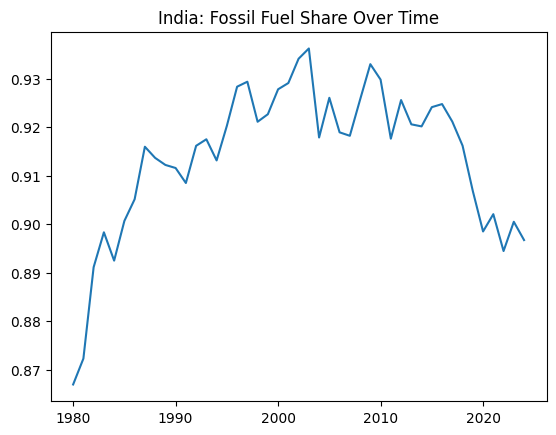

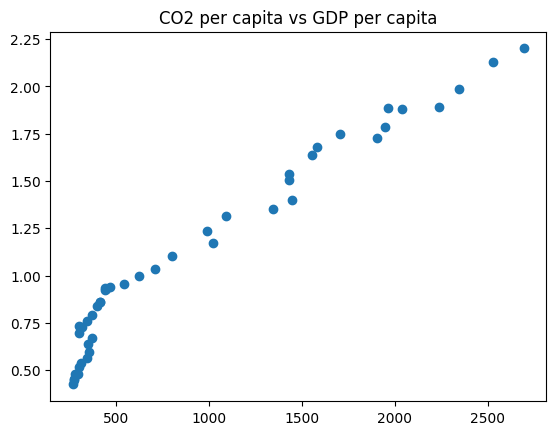

In [20]:
#  plotting visuals

plt.figure()
plt.plot(ekc_df['Year'], ekc_df['fossil_share'])
plt.title("India: Fossil Fuel Share Over Time")
plt.show()

plt.figure()
plt.scatter(ekc_df['GDP_pc'], ekc_df['CO2_pc'])
plt.title("CO2 per capita vs GDP per capita")
plt.show()


In [ ]:
# stationarity test


for col in ['ln_CO2_pc', 'ln_GDP_pc', 'fossil_share']:
    print(col, adfuller(ekc_df[col])[1])


ln_CO2_pc 0.8570266492130741
ln_GDP_pc 0.9941163211899597
fossil_share 0.018909361071760375


In [55]:
y = ekc_df['ln_CO2_pc']
X = ekc_df[['ln_GDP_pc', 'fossil_share']]

sel = ardl_select_order(
    endog=y,
    exog=X,
    maxlag=2,
    maxorder=2,
    ic='aic',
    trend='c'
)

ardl_model = sel.model.fit()
print(ardl_model.summary())

                              ARDL Model Results                              
Dep. Variable:              ln_CO2_pc   No. Observations:                   45
Model:                  ARDL(1, 0, 0)   Log Likelihood                  97.258
Method:               Conditional MLE   S.D. of innovations              0.027
Date:                Thu, 29 Jan 2026   AIC                           -184.516
Time:                        22:19:46   BIC                           -175.595
Sample:                             1   HQIC                          -181.208
                                   45                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2220      0.483     -2.533      0.015      -2.197      -0.247
ln_CO2_pc.L1        0.8662      0.041     21.205      0.000       0.784       0.949
ln_GDP_pc.L0        0.0778      

In [59]:
from statsmodels.tsa.ardl import UECM

y = ekc_df['ln_CO2_pc']
X = ekc_df[['ln_GDP_pc', 'fossil_share']]

uecm = UECM(
    endog=y,
    exog=X,
    lags=1,        # from ARDL(1,0,0)
    order=1,
    trend='c'
)

uecm_res = uecm.fit()
print(uecm_res.summary())



                              UECM Model Results                              
Dep. Variable:            D.ln_CO2_pc   No. Observations:                   45
Model:                  UECM(1, 1, 1)   Log Likelihood                  98.783
Method:               Conditional MLE   S.D. of innovations              0.474
Date:                Thu, 29 Jan 2026   AIC                           -183.567
Time:                        22:54:54   BIC                           -171.077
Sample:                             1   HQIC                          -178.935
                                   45                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.7674      0.557     -1.377      0.176      -1.895       0.361
ln_CO2_pc.L1         -0.0965      0.046     -2.079      0.044      -0.191      -0.003
ln_GDP_pc.L1          0.

In [60]:
hypothesis = (
    "ln_GDP_pc.L1 = 0, "
    "fossil_share.L1 = 0"
)

f_test = uecm_res.f_test(hypothesis)
print(f_test)


<F test: F=2.2619264506003707, p=0.11799641144230578, df_denom=38, df_num=2>
